# Deep Learning &mdash; Assignment 2

Second assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_September 2020_

-----

**Names:** Eugenia Martynova (s1038931) & Denise Meerkerk (s4467132)

**Group:** 3

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Learn how to define and train a neural network with pytorch
2. Experiment with convolutional neural networks
3. Investigate the effect of dropout and batch normalization

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book,
* `sounddevice` to play audio,
* `python_speech_features` to compute MFCC features.

All libraries can be installed with `pip install`.

In [6]:
pip install d2l

Note: you may need to restart the kernel to use updated packages.


In [7]:
%matplotlib inline
import os
import numpy as np
from d2l import torch as d2l
import torch
from torch import nn
from scipy.io import wavfile

In [8]:
# This is to launch and use terminal from google colab
'''
!pip install kora
from kora import console
console.start() 
'''

'\n!pip install kora\nfrom kora import console\nconsole.start() \n'

## 2.1 Digits dataset

The d2l book uses a dataset of images as a running example (FashionMNIST). In this assignment we will investigate CNNs in a completely different domain: speech recognition.

The dataset we use is the free spoken digits dataset, which can be found on https://github.com/Jakobovski/free-spoken-digit-dataset. This dataset consists of the digits 0 to 9, spoken by different speakers. The data comes as .wav files.

**Use `git clone` to download the dataset.**

##### use command below in terminal (the fourth item below files on the left of the screen)
`git clone https://github.com/Jakobovski/free-spoken-digit-dataset`

Below is a function to load the data. We pad/truncate each sample to the same length.
The raw audio is usually stored in 16 bit integers, with a range -32768 to 32767, where 0 represents no signal. Before using the data, it should be normalized. A common approach is to make sure that the data is between 0 and 1 or between -1 and 1.

**Update the below code to normalize the data to a reasonable range**

In [9]:
samplerate = 8000
def load_waveform(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    # Take first 6000 samples from waveform. With a samplerate of 8000 that corresponds to 3/4 second
    # Pad with 0s if the file is shorter
    waveform = np.pad(waveform,(0,size))[0:size]
    # Normalize waveform between -1 and 1. 
    waveform = waveform/32768
    return waveform

The following code loads all .wav files in a directory, and makes it available in a pytorch dataset.

**Load the data into a variable `data`**

In [10]:
class SpokenDigits(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.x = self.x.unsqueeze(1) # One channel
        self.y = torch.from_numpy(np.array(digits_y))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


data_path = "free-spoken-digit-dataset/recordings"
data = SpokenDigits(data_path)


In [11]:
# Since SpokenDigits returns the number of samples in __len__ method, we can just use len(data) to
# obtain this number
print(len(data))

3000


In [12]:
# To check a sample dimensionality we use the size() method of the first sample
print(data.x[0].size())

torch.Size([1, 6000])


In [13]:
# To obtain number of classes, we check the number of unique items in data.y array
print(len(np.unique(data.y.numpy())))

10


**Describe the dataset: how many samples are there, what is their dimensionality? How many classes are there?**

There are 3000 samples of 1x6000 dimensionality and 10 classes.

Here is code to play samples from the dataset to give you an idea what it "looks" like.

**this did not work for us, that is why it's commented.**

In [14]:
'''
import sounddevice as sd
def play(sample):
    sd.play(sample[0][0], samplerate)
    print(sample[1])
play(data[0])
'''

'\nimport sounddevice as sd\ndef play(sample):\n    sd.play(sample[0][0], samplerate)\n    print(sample[1])\nplay(data[0])\n'

In [15]:
train_prop = 2/3
train_count = int(len(data) * train_prop)
train, test = torch.utils.data.random_split(data, [train_count, len(data)-train_count])


The code above is code to split the data into a training and test set. It uses 2/3 of the data for training.

**Discuss an advantage and disadvantage of using more of the data for training**

Increase of training data share might help to increase model accuracy since we provide a network with more information about the data. In other words, a model just has more samples to learn from. However, with this approach, we risk missing overfitting because if the test set is too small, there is a larger chance of not having a representative test set. Then, a training set might contain all the "difficult" samples and samples from a test set would be easy to classify. So, we won't be able to evaluate the generalisation properties of the model.


On the contrary, if a test set share is too high, we will estimate the generalization abilities of the model well. However, the network accuracy would be smaller than we could potentially get with the data.

Finally, we split the data into batches:

In [16]:
data_params = {'batch_size': 32}
train_iter = torch.utils.data.DataLoader(train, **data_params)
test_iter  = torch.utils.data.DataLoader(test,  **data_params)

## 2.2 One dimensional convolutional neural network

We will now define a network architecture. We will use a combination of convolutional layers and pooling.
Note that we use 1d convolution and pooling here, instead of the 2d operations used for images.

**Complete the network architecture, look at the d2l book chapters 6 and 7 for examples**

In [17]:
net = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))

**The first fully connected layer has input dimension 11872, where does that number come from?**

The dimensionality of the network input is $1\times6000$. Each layer changes the dimentionality of the data. All the convolutional layers in our network use valid padding and stride 1, therefore the dimensionality of their output would be $1\times(n - k +1)$ where $n$ is the input length and $k$ is the kernel size. Also after each convolution layers the number of channels is changed. All the pooling layers have kernel size 2 and stride 2, hence the dimentionality of their output would be $ \lfloor n/2 \rfloor$. 

We will use the notation $(c\times n_h\times n_w)$ as input/output size where $c$ is the number of channels, $n_h$ - first data dimension, $n_w$ - second data dimension. Here are the changes which occur in our network step by step:

1. Conv1d. Input -  $1\times1\times6000$, output $4\times1\times(6000 - 5 +1) = 4\times1\times5996$
2. AvgPool1d. Input - $4\times1\times5996$, output $4\times1\times \lfloor 5996/2 \rfloor = 4\times1\times2998$
3. Conv1d. Input -  $4\times1\times2998$, output $8\times1\times2994$
4. AvgPool1d. Input - $8\times1\times2994$, output $8\times1\times1497$
5. Conv1d. Input -  $8\times1\times1497$, output $16\times1\times1493$
6. AvgPool1d. Input - $16\times1\times1493$, output $16\times1\times746$
7. Conv1d. Input -  $16\times1\times746$, output $32\times1\times742$
8. AvgPool1d. Input - $32\times1\times742$, output $32\times1\times371$

Then, we use Flatten operation which transforms a tensor of size $(c\times n_h\times n_w)$ to a 1-d vector $1 \times n$. The size of the previous layer output is $32\times1\times371$, hence $n = 32\times 371 = 11872$

**How many parameters are there in the model? I.e. the total number of weights and biases**

In [18]:
param_num = sum([param.nelement() for param in net.parameters()])
print(param_num)

1532090


**Suppose that instead of using convolutions, we had used only fully connected layers. How many parameters would be needed in that case approximately?**

A fully connected layer consists of weighs $\mathbf{W}$ and biases $\mathbf{b}$. The dimensionality of $\mathbf{W}$ depend on input and output layer sizes: for $N$ inputs and $H$ outputs in $N\times H$. The dimensionality of $\mathbf{b}$ depends on output size and is $1\times H$. Hence the number of parameters in a fully connected layer is $(N+1)\times H$.

The number of parameters in 3 last fully connected layers in our network is:

1. $(11872 +1)\times 128 = 1519744$
2. $(128 +1)\times 64 = 8256$
3. $(64 +1)\times 10 = 650$

Which gives 1528650 parameters.

If we replace 4 convolution layers with fully connected layers with the same number of hidden units $H$, we would get the following number of parameters:

$(((((6000 +1)\times H + 1)\times H +1)\times H +1)\times H +1) \sim O(H^4)$

Even for $H=100$ it gives about 100 million additional parameters, whereas convolution layers only give $1532090 - 1528650 = 3440$ additional parameters.

The FashionMNIST dataset used in the book has 60000 training examples. How large is our training set? How would the difference affect the number of epochs that we need? Compare to chapter 6.6 and 7.1 of the book.

**How many epochs do you think are needed?**

Out training set has 2000 samples (since we have 3000 samples in total and leave 2/3 in the training set). So, our training set is 30 times smaller than FashionMNIST. Since we have less training data, we will definitely need more epoch for training convergence. But it is difficult to give an estimate of how many since we don't know which other properties of data affect training convergence. Also in our case, the share of the test set is larger, in FashionMNIST training set size is 6/7. A naive way to guess would be to say that we need about 30 times more epochs, so 300. In practice, we found that with a proper LR about 70 epochs is enough for the initial network.

In [19]:
lr, num_epochs = 0.07, 100 


We will use the code from the d2l book to train the network.
In particular, the `train_ch6` function, defined in [chapter 6.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html#training). This function is available in the `d2l` library.
However, this function has a bug: it only initializes the weights for 2d convolutional layers, not for 1d convolutional layers.

**Make a copy of the train_ch6 function, and correct the error**

In [20]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [21]:
def train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv1d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

**Now train the network.**

loss 0.000, train acc 1.000, test acc 0.544
963.7 examples/sec on cpu


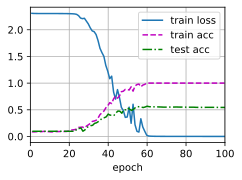

In [22]:
train(net, train_iter, test_iter, num_epochs, lr)

**Is the training converged?**

If the training has not converged, maybe you need to change the number of epochs and/or the learning rate.

Document the changes that you made and their effect:

At first, we did not increase epoch numbers significantly (probably we started from 20) because we wanted to speed up the choice of learning rate by comparison of how learning curves change at the beginning of training. But with different learning rates in 20 epochs, there was no change. We increased the number of epochs to something close to 100. Then, we tried to decrease the LR to typical values of 0.005 0.001, then increase to 0.05 and 0.1. We didn't get convergence with any of these values but with higher learning rates (0.05 and 0.1) accuracy started to increase (and loss to decrease), however then it diverged again. So we tried different values in between. We found that 0.7, 0.75 and 0.8 LR work. In the end, we chose LR = 0.7 and adjusted the number of epochs according to convergence. 

It should be noticed that training is rather unstable. Sometimes it does not converge at all or it might start to converge at a different point.


## 2.3 Questions and evaluation

**Does the network look like it is overfitting or underfitting?**

The network is severely overfitting. From the visualisation of training curves and reported final loss and accuracies, we can see that the network memorized training data perfectly, but accuracy for test data is has reached plateo at 0.705 (this number varies each training).


**Is what we have here a good classifier? Could it be used in a realistic application?**

We think that the classifier is pretty decent. For a problem with 10 classes, the probability of the correct choice of a class at random is 10% and the accuracy of our classifier is 70.5%.

It depends on the goal of a specific application of this classifier if it is good enough to be used in real life. Since our task is recognition of spoken digits, which is not that hard for humans, the users of the system in which the classifier is going to be used is would probably expect a higher accuracy. One possible application is speech recognition. Then it is sensible to suggest that from the user perspective the system which makes errors in 3 of 10 cases is insufficient.



**Do you think there is enough training data compared to the dimensions of the data and the number of parameters?**

We have 2000 training samples with 6000 features and around 1.5 million parameters, which is $O(100)$ times larger than the number of samples. So, our problem is high-dimensional with the number of observations less than the number of features. The model with 1.5 million parameters seems to be rather complex. Since the network severely overfits, we think that this model's capacity is too large for the used data set. It can memorize training samples well, thus generalization suffers. 

It is a good idea to try a simpler model for this task.

**How could the classifier be improved?**


As we started to argue in the previous question, it is sensible to try a simpler model - fewer filters and/or layers. Also different kernel sizes can be tried.

Another common solution to the overfitting problem is the addition of regularization. It can be L1 or L2 regularization or dropout. Also from the convergence curves, we see that for a very long time hardly any learning occurs, but then training converges quite rapidly. This might be a sign that our error landscape is challenging (for instance it might have plateaus and saddle points, local vs global structure problem). We use SDG optimizer, which is known to be affected by these issues, hence it is sensible to try another optimizer, e.g. Adam. 

Batch normalization can speed up the convergence as well because it scales the input to belong to the "most non-linear" interval of activation functions input. 

Also, different normalisation technique might significantly improve the convergence. We kept normalization to [-1,1] interval as was suggested initially, but also tried [0,1] (it didn't work at all) and zero mean + unit variance normalization of features (wavelengths). The latter worked noticeably better, however, we normalized the whole data set before splitting into training and test data. This is not the correct way to normalize - it should be done with training set statistics for both train and test sets to prevent the spread of test data information to the model during training. For proper normalization, we need to dive into Pytorch objects which would require additional time.

Lastly, more data is always better, so we could try to get a bigger dataset :)

**The free spoken digits datasets has recordings from several different speakers. Is the test set accuracy a good measure of how well the trained network would perform for recognizing the voice of a new speaker? And if not, how could that be tested instead?**

We think that the fact that no new speakers appear in our test set is indeed a flaw in our evaluation. We can split the data differently: leave the balanced distribution of digits in training and test sets, but do not mix the same speaker between these datasets. Then test accuracy would be more informative evaluation measure.

Also, we could try to look for data augmentation methods for speech recordings. If such methods exist, the addition of data augmentation should help to build a more accurate and robust model. And because of augmentation, we would have some "new" voices in the test set.

## 2.4 Variations

One way in which the training might be improved is with dropout or with batch normalization.

**Make a copy of the network architecture below, and add dropout**

Hint: see [chapter 7.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html#architecture) for an example that uses dropout.

loss 0.035, train acc 0.992, test acc 0.733
999.4 examples/sec on cpu


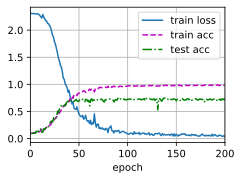

In [23]:
num_epochs = 200
net_dropout = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(64, 10))
train(net_dropout, train_iter, test_iter, num_epochs, lr)

**How does dropout change the results?**

Addition of dropout slowed down the convergence and made it less steady. Also, train and test accuracy curves started to diverge later and for quite a few epochs test set accuracy was slightly higher. In the end, we got a 4.2% increase in test accuracy, which is rather good. We can also see that training accuracy hasn't reached 100%. Probably if we continued training for longer, we would be able to get slightly better accuracy.

We tried other dropout options as well. Decrease of FC layers dropout to 0.3 fails to suppress overfitting. With 0.4 the results were not very different, but the final accuracy seemed worse. We also tried adding a small dropout (0.1-0.2) to convolution layers, the network was not able to learn.


**Make a copy of the original network architecture, and add batch normalization to all convolutional and linear layers.**

Hint: see [chapter 7.5](http://d2l.ai/chapter_convolutional-modern/batch-norm.html#concise-implementation) for an example.

loss 0.003, train acc 1.000, test acc 0.773
801.1 examples/sec on cpu


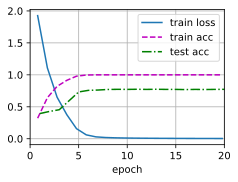

In [24]:
num_epochs = 20
net_batchnorm = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.BatchNorm1d(4), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(4, 8, kernel_size=5), nn.BatchNorm1d(8), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.BatchNorm1d(16), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.BatchNorm1d(32), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(11872, 128), nn.BatchNorm1d(128 ), nn.ReLU(),
    nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
    nn.Linear(64, 10))
train(net_batchnorm, train_iter, test_iter, num_epochs, lr)

**How does batch normalization change the results?**

Batch normalization increased convergence dramatically (already around 7th epoch) and significantly improved the final test accuracy. Hurray!

## 2.5 Bonus: feature extraction

Given enough training data a deep neural network can learn to extract features from raw data like audio and images. However, in some cases it is still necesary to do manual feature extraction. For speech recognition, a popular class of features are [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

Here is code to extract these features. You will need to install the `python_speech_features` first.

In [25]:
pip install python_speech_features

Note: you may need to restart the kernel to use updated packages.


In [26]:
from python_speech_features import mfcc

def load_waveform_mfcc(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    waveform = np.pad(waveform,(0,size))[0:size] / 32768
    return np.transpose(mfcc(waveform, samplerate))

**Implement a variation of the dataset that uses these features**

In [27]:
''' 
This class is copied from the class SpokenDigits. The line where the waveform is
defined, the function load_waveform is replaced with load_waveform_mfcc.
 '''
class SpokenDigitsMFCC(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform_mfcc(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.x = self.x.unsqueeze(1) # One channel
        self.y = torch.from_numpy(np.array(digits_y))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

data_mfcc = SpokenDigitsMFCC(data_path)
train_count_mfcc = int(len(data_mfcc) * train_prop)
train_mfcc, test_mfcc = torch.utils.data.random_split(data_mfcc, [train_count_mfcc, len(data_mfcc)-train_count_mfcc])
train_iter_mfcc = torch.utils.data.DataLoader(train_mfcc, **data_params)
test_iter_mfcc  = torch.utils.data.DataLoader(test_mfcc,  **data_params)

The MFCC features will have 13 channels instead of 1 (the `unsqueeze` operation is not needed). 

**Inspect the shape of the data, and define a new network architecture that accepts data with this shape**

The number of data samples is: 3000
The dimension of a single sample is: torch.Size([1, 13, 74])
The number of classes is: 10


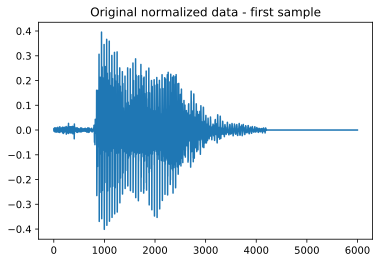

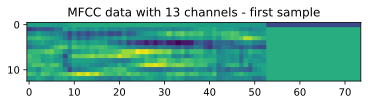

In [28]:
import matplotlib.pyplot as plt

# Since SpokenDigits returns the number of samples in __len__ method, we can just use len(data) to
# obtain this number
print('The number of data samples is:',len(data_mfcc))
# To check a sample dimensionality we use the size() method of the first sample
print('The dimension of a single sample is:',data_mfcc.x[0].size())
# To obtain number of classes, we check the number of unique items in data.y array
print('The number of classes is:',len(np.unique(data_mfcc.y.numpy())))
data_mfcc.x[0][0]

plt.figure()
plt.plot(data.x[0][0])
plt.title("Original normalized data - first sample")
plt.show()

plt.figure()
plt.imshow(data_mfcc.x[0][0])
plt.title("MFCC data with 13 channels - first sample")
plt.show()

In [29]:
# new architecture for new shapes
# adjusted copy of the batch normalization

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,13,74)


num_epochs = 20
net_batchnorm_mfcc = torch.nn.Sequential(
    Reshape(), # with reshape it is slightly more robust
    nn.Conv2d(1, 8, kernel_size=(2,3)), nn.BatchNorm2d(8), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(8, 16, kernel_size=3), nn.BatchNorm2d(16), nn.ReLU(),
    # no AvgPool here, because the channels shrink too fast.

    nn.Conv2d(16, 32, kernel_size=3), nn.BatchNorm2d(32), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(512, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))


X = torch.randn(size=(1, 1, 13, 74), dtype=torch.float32)
for layer in net_batchnorm_mfcc:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 13, 74])
Conv2d output shape: 	 torch.Size([1, 8, 12, 72])
BatchNorm2d output shape: 	 torch.Size([1, 8, 12, 72])
ReLU output shape: 	 torch.Size([1, 8, 12, 72])
AvgPool2d output shape: 	 torch.Size([1, 8, 6, 36])
Conv2d output shape: 	 torch.Size([1, 16, 4, 34])
BatchNorm2d output shape: 	 torch.Size([1, 16, 4, 34])
ReLU output shape: 	 torch.Size([1, 16, 4, 34])
Conv2d output shape: 	 torch.Size([1, 32, 2, 32])
BatchNorm2d output shape: 	 torch.Size([1, 32, 2, 32])
ReLU output shape: 	 torch.Size([1, 32, 2, 32])
AvgPool2d output shape: 	 torch.Size([1, 32, 1, 16])
Flatten output shape: 	 torch.Size([1, 512])
Linear output shape: 	 torch.Size([1, 128])
ReLU output shape: 	 torch.Size([1, 128])
Linear output shape: 	 torch.Size([1, 64])
ReLU output shape: 	 torch.Size([1, 64])
Linear output shape: 	 torch.Size([1, 10])


**Train the network with the mfcc features.**

loss 0.003, train acc 1.000, test acc 0.972
6491.4 examples/sec on cpu


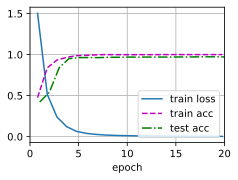

In [30]:
train(net_batchnorm_mfcc, train_iter_mfcc, test_iter_mfcc, num_epochs, lr)

**Is there a neural-network based alternative to mfcc features?**



Considering that (almost) all scientific papers on speech recognistion use mfcc or an equivalant transformation on their input data, we think that there exists no equivalent alternative based on neural-networks. In any case not a method that works better than converting your input data once form `.wav` format to mfcc format. You might be able to make it if you make custom layers to calculate the non-linear steps. Below you find the steps to calculate the mfcc transformation from the [wikipedia page](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). In addition some conceptual ideas about how such a neural network could like.

1.   Take the Fourier transform of (a windowed excerpt of) a signal.
  * For this step a neural network layer might just do the fourier transform, but the windowsize could be one of the parameters the neural network minimizes error for. Taking a window from the original data looks a lot like a 1d convolution.
1. Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
  * Triangular overlapping windows might be hard to spontaniously arise in the neural network, but you could hardcode something similar. This would be similar to a 2d convolutional layer, instead with a triangular shape instead of rectangular.
1.   Take the logs of the powers at each of the mel frequencies.
  * taking a log function is not very linear, but I have no objection to making a layer that just takes the log. It might be equivalent to an activation function.
1.   Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
  * This would be similar to an activation function like the sigmoid, only then a cosine is used.
1.   The MFCCs are the amplitudes of the resulting spectrum.
  * the output would be an image. (For example for the data in this assignment a `13 x 74` shaped image) 



## The end

Well done! Please double check the instructions at the top before you submit your results.